The dataset used in this notebook is Tesla stock history from 2014 to 2017. You can find the .csv file in the project folder.

In [1]:
import math
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

INPUT_FILE_PATH = 'tesla_stocks.csv'
INPUT_DATA_COLUMN = 'Close'
TRAIN_SIZE_PERCENTAGE = 50
TRAIN_WINDOW_SIZE = 5

### Step 1. Loading dataset

In [2]:
data = pd.read_csv(INPUT_FILE_PATH)

In [3]:
data_to_use = data[INPUT_DATA_COLUMN].values

### Step 2. Data preprocessing 

#### Step 2.1 Scaling data

In [4]:
scaler = StandardScaler()

In [5]:
scaled_data = scaler.fit_transform(data_to_use.reshape(-1, 1))

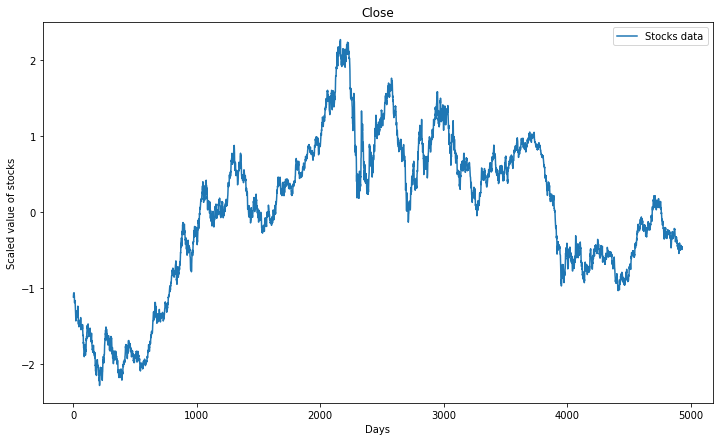

In [6]:
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title(INPUT_DATA_COLUMN)
plt.xlabel('Days')
plt.ylabel('Scaled value of stocks')
plt.plot(scaled_data, label='Stocks data')
plt.legend()
plt.show()

In [7]:
def window_data(data, window_size):
    '''
    This function is used to create Features and Labels datasets. By windowing the data.
    
    Input: data - dataset used in the project
           window_size - how many data points we are going to use to predict the next datapoint in the sequence 
                       [Example: if window_size = 1 we are going to use only the previous day to predict todays stock prices]
    
    Outputs: X - features splitted into windows of datapoints (if window_size = 1, X = [len(data)-1, 1])
             y - 'labels', actually this is the next number in the sequence, this number we are trying to predict
    '''
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y


#### Step 2.2 Windowing the data with window_data function

In [8]:
X, y = window_data(scaled_data, TRAIN_WINDOW_SIZE)

train_size = int(math.floor(len(X) / 100 * TRAIN_SIZE_PERCENTAGE))

print("train size: {}".format(train_size))

train size: 2450


#### Step 2.3 Splitting data to training and testing parts

In [9]:
X_train  = np.array(X[:train_size])
y_train = np.array(y[:train_size])

X_test = np.array(X[train_size:])
y_test = np.array(y[train_size:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (2450, 5, 1)
y_train size: (2450, 1)
X_test size: (2477, 5, 1)
y_test size: (2477, 1)


### Step 3. Define the network

In [10]:
#Hyperparameters used in the network
batch_size = TRAIN_WINDOW_SIZE #how many windows of data we are passing at once
window_size = TRAIN_WINDOW_SIZE #how big window_size is (Or How many days do we consider to predict next point in the sequence)
hidden_layer = 256 #How many units do we use in LSTM cell
clip_margin = 4 #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
learning_rate = 0.001 
epochs = 200 

#### Step 3.1 Define palceholders

In [11]:
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])

In this notebook I am implementing LSTM cell from scratch using TensorFlow. In the next 2 cells you will find weights and implementation of the LSTM cell.

In [12]:
# LSTM weights
#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

In [13]:
## Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))

This is definition of LSTM cell. The best explanation of the LSTM you will find [here](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)


![](lstm_cell.png)

*This image is from Colah's blog*

In [14]:
def LSTM_cell(input, output, state):
    
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    
    state = state * forget_gate + input_gate * memory_cell
    
    output = output_gate * tf.tanh(state)
    return state, output

## Time to define loop for the network

In [15]:
outputs = []
for i in range(batch_size): #Iterates through every window in the batch
    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)
    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)

In [16]:
outputs

[<tf.Tensor 'add_45:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_91:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_137:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_183:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_229:0' shape=(1, 1) dtype=float32>]

#### Step 3.3 Define loss

In [17]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))
    
loss = tf.reduce_mean(losses)

#### Step 3.4 Define optimizer with gradient clipping

In [18]:
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

### Time to train the network 

In [19]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [20]:
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
        
    step = epochs / 100 * 10
    if i % step == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

('Epoch 0/200', ' Current loss: 0.0356724709272')
('Epoch 20/200', ' Current loss: 0.0441826507449')
('Epoch 40/200', ' Current loss: 0.0286058504134')
('Epoch 60/200', ' Current loss: 0.00650003133342')
('Epoch 80/200', ' Current loss: 0.00437320675701')
('Epoch 100/200', ' Current loss: 0.00358026544563')
('Epoch 120/200', ' Current loss: 0.00336540513672')
('Epoch 140/200', ' Current loss: 0.00321939191781')
('Epoch 160/200', ' Current loss: 0.00310203875415')
('Epoch 180/200', ' Current loss: 0.00305237760767')


In [21]:
sup =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j][0])

In [22]:
tests = []
i = 0
while i+batch_size <= len(X_test):
    
    o = session.run([outputs], feed_dict={inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)

In [23]:
tests_new = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])

In [24]:
print("Data Size: {}".format(len(scaled_data)))
print("Train Size: {}".format(train_size))

scaled_data_len = len(scaled_data)

test_results = [None for i in range(scaled_data_len)] + tests_new[scaled_data_len + 1:]

print("Test Size: {}".format(len(test_results)))

# test_results = []
# for i in range(len(scaled_data)):
#     if i < train_size:
#         test_results.append(None)
#     else:
#         test_results.append(tests_new[i - train_size])

Data Size: 4932
Train Size: 2450
Test Size: 4932


### Plotting predictions from the network

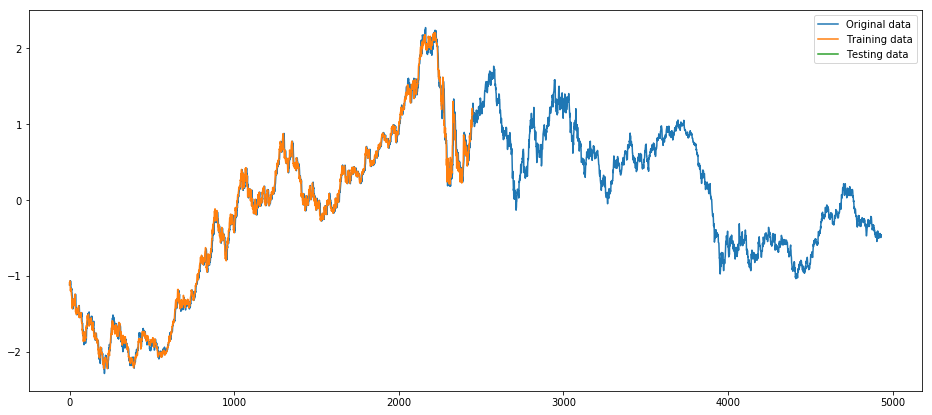

In [25]:
plt.figure(figsize=(16, 7))
plt.plot(scaled_data, label='Original data')
plt.plot(sup, label='Training data')
plt.plot(test_results, label='Testing data')
plt.legend()
plt.show()

In [26]:
session.close()